In [1]:
import datetime
import gc

import matplotlib.pyplot as plt
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split, KFold, GridSearchCV, cross_val_score

from sklearn.ensemble import GradientBoostingRegressor
from lightgbm import LGBMRegressor

%matplotlib inline

In [2]:
df = pd.read_csv('/Kaggle/input/realestatepriceprediction/train.csv')

X = df.drop('Price', axis=1)
y = df[['Price']]

X_final = pd.read_csv('/Kaggle/input/realestatepriceprediction/test.csv')

preds_final = pd.DataFrame()
preds_final['Id'] = X_final['Id'].copy()

X.set_index('Id', inplace=True)
X_final.set_index('Id', inplace=True)

print('Строк в трейне:' ,  X.shape[0])
print('Строк в тесте', X_final.shape[0])

# Удалим ненужные файлы
gc.collect()  

Строк в трейне: 10000
Строк в тесте 5000


0

In [3]:
def reduce_mem_usage(X):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = X.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in X.columns:
        col_type = X[col].dtype
        
        if col_type != object:
            c_min = X[col].min()
            c_max = X[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    X[col] = X[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    X[col] = X[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    X[col] = X[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    X[col] = X[col].astype(np.int64)  
            else:
#                 if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
#                     X[col] = X[col].astype(np.float16)
#                 elif

                if c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    X[col] = X[col].astype(np.float32)
                else:
                    X[col] = X[col].astype(np.float64)
        else:
            X[col] = X[col].astype('category')

    end_mem = X.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return X

In [4]:
X = reduce_mem_usage(X)
X_final = reduce_mem_usage(X_final)

Memory usage of dataframe is 1.45 MB
Memory usage after optimization is: 0.51 MB
Decreased by 65.1%
Memory usage of dataframe is 0.72 MB
Memory usage after optimization is: 0.24 MB
Decreased by 66.4%


In [5]:
X['Rooms'].value_counts()

2.0     3880
1.0     3705
3.0     2235
4.0      150
5.0       18
0.0        8
10.0       2
19.0       1
6.0        1
Name: Rooms, dtype: int64

In [6]:
X['KitchenSquare'].value_counts().sort_values()

54.0         1
72.0         1
96.0         1
66.0         1
48.0         1
40.0         1
2014.0       1
35.0         1
60.0         1
78.0         1
27.0         1
84.0         1
42.0         1
62.0         1
39.0         1
1970.0       1
36.0         1
75.0         1
26.0         1
21.0         1
29.0         1
23.0         1
73.0         1
123.0        1
31.0         1
63.0         1
53.0         1
30.0         2
58.0         2
32.0         2
51.0         2
43.0         2
25.0         2
112.0        2
41.0         2
37.0         2
22.0         3
2.0          4
18.0         6
19.0        11
17.0        12
20.0        14
16.0        16
3.0         22
15.0        31
4.0         39
14.0        51
13.0        67
11.0       233
12.0       249
7.0        609
0.0        697
9.0        843
6.0       1038
10.0      1075
5.0       1169
8.0       1306
1.0       2460
Name: KitchenSquare, dtype: int64

In [7]:
X['HouseFloor'].sort_values().unique()

array([  0.,   1.,   2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.,  10.,
        11.,  12.,  13.,  14.,  15.,  16.,  17.,  18.,  19.,  20.,  21.,
        22.,  23.,  24.,  25.,  26.,  27.,  28.,  29.,  30.,  31.,  32.,
        36.,  37.,  38.,  39.,  40.,  44.,  45.,  47.,  48.,  99., 117.],
      dtype=float32)

In [8]:
X['Floor'].sort_values().unique()

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 31, 32, 33, 37, 42],
      dtype=int8)

In [9]:
(X['Floor'] > X['HouseFloor']).sum()

1825

In [10]:
X['HouseYear'].sort_values().unique()

array([    1910,     1912,     1914,     1916,     1917,     1918,
           1919,     1928,     1929,     1930,     1931,     1932,
           1933,     1934,     1935,     1936,     1937,     1938,
           1939,     1940,     1941,     1942,     1947,     1948,
           1950,     1951,     1952,     1953,     1954,     1955,
           1956,     1957,     1958,     1959,     1960,     1961,
           1962,     1963,     1964,     1965,     1966,     1967,
           1968,     1969,     1970,     1971,     1972,     1973,
           1974,     1975,     1976,     1977,     1978,     1979,
           1980,     1981,     1982,     1983,     1984,     1985,
           1986,     1987,     1988,     1989,     1990,     1991,
           1992,     1993,     1994,     1995,     1996,     1997,
           1998,     1999,     2000,     2001,     2002,     2003,
           2004,     2005,     2006,     2007,     2008,     2009,
           2010,     2011,     2012,     2013,     2014,     2

In [11]:
X[X['HouseYear'] > 2020].head()


,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2
Id,,,,,,,,,,,,,,,,,,
10814,109,1.0,37.265072,20.239714,9.0,9,12.0,20052011,0.136330,B,B,30,6141,10,262.0,3,6,B
11607,147,2.0,44.791836,28.360394,5.0,4,9.0,4968,0.319809,B,B,25,4756,16,2857.0,5,8,B


In [12]:
X[X['Square'] < 30].describe()

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1
count,105.000000,105.000000,105.000000,88.000000,105.000000,105.000000,105.000000,105.000000,105.000000,105.000000,105.000000,105.000000,52.000000,105.000000,105.000000
mean,54.066667,1.095238,23.798742,18.576368,3.180952,6.800000,9.523809,1980.228571,0.132693,22.790476,4649.676190,10.000000,1592.192261,1.561905,3.600000
std,42.972099,0.427960,8.104394,11.455103,2.670281,5.455061,6.495702,19.801543,0.111388,17.319229,3678.205699,27.968389,1068.303589,1.580675,5.037551
min,0.000000,0.000000,1.136859,0.873147,0.000000,1.000000,0.000000,1931.000000,0.000000,0.000000,168.000000,0.000000,30.000000,0.000000,0.000000
25%,23.000000,1.000000,22.682705,13.557135,1.000000,3.000000,5.000000,1968.000000,0.034656,4.000000,915.000000,0.000000,776.250000,0.000000,0.000000
50%,30.000000,1.000000,27.293798,16.515539,3.000000,5.000000,9.000000,1976.000000,0.072158,25.000000,5048.000000,2.000000,1548.000000,1.000000,2.000000
75%,90.000000,1.000000,29.109535,19.448193,5.000000,9.000000,12.000000,1977.000000,0.219006,37.000000,6558.000000,6.000000,2350.000000,3.000000,5.000000
max,178.000000,3.000000,29.947691,79.767967,10.000000,28.000000,25.000000,2019.000000,0.460556,53.000000,13670.000000,141.000000,4702.000000,5.000000,23.000000


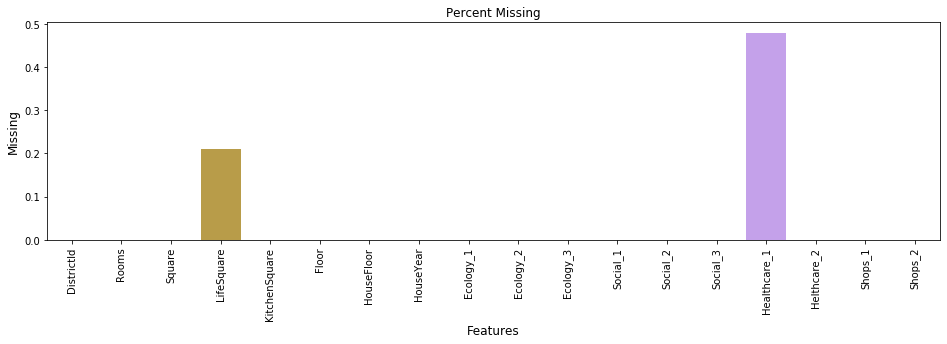

In [13]:
import seaborn as sns

nan_df = (X.isna().sum() / X.shape[0]).reset_index()
nan_df.columns=['feature', 'nan_percent']

plt.figure(figsize=(16,4))
sns.barplot(nan_df['feature'], nan_df['nan_percent'])
plt.title('Percent Missing')
plt.ylabel('Missing', fontsize=12)
plt.xlabel('Features', fontsize=12)
plt.xticks(rotation=90)
plt.show()

In [14]:
X.DistrictId.nunique()

205

In [15]:
dict(X['DistrictId'].value_counts())

{27: 851,
 1: 652,
 23: 565,
 6: 511,
 9: 294,
 62: 247,
 30: 228,
 58: 179,
 53: 174,
 21: 165,
 52: 143,
 8: 142,
 11: 129,
 46: 119,
 61: 118,
 45: 116,
 74: 114,
 34: 111,
 57: 107,
 44: 104,
 99: 97,
 101: 97,
 47: 97,
 13: 97,
 7: 92,
 48: 90,
 29: 89,
 94: 89,
 41: 87,
 3: 82,
 84: 80,
 28: 79,
 2: 78,
 22: 78,
 25: 77,
 85: 76,
 93: 73,
 37: 72,
 90: 72,
 96: 71,
 59: 67,
 75: 66,
 26: 65,
 12: 64,
 88: 64,
 128: 64,
 66: 62,
 67: 61,
 17: 59,
 55: 58,
 39: 57,
 10: 56,
 105: 55,
 31: 55,
 18: 51,
 111: 49,
 119: 49,
 0: 48,
 78: 46,
 91: 44,
 124: 43,
 63: 43,
 129: 43,
 42: 42,
 79: 42,
 109: 41,
 113: 41,
 77: 40,
 54: 37,
 15: 36,
 38: 36,
 24: 35,
 5: 34,
 56: 34,
 32: 34,
 103: 33,
 123: 32,
 19: 31,
 80: 31,
 33: 31,
 83: 31,
 69: 29,
 138: 29,
 130: 29,
 64: 28,
 108: 27,
 86: 27,
 70: 27,
 87: 27,
 120: 26,
 122: 25,
 100: 25,
 121: 25,
 20: 24,
 89: 24,
 107: 23,
 35: 22,
 169: 22,
 98: 21,
 167: 20,
 144: 20,
 145: 19,
 146: 18,
 81: 18,
 134: 18,
 73: 17,
 36: 17,
 

In [16]:
class FeatureImputer:
    """Заполнение пропусков и обработка выбросов"""
    
    def __init__(self):
        self.medians=None
        
    def fit(self, X):
        self.medians = X.median()
    
    def transform(self, X):
        
        # Rooms
        X.loc[X['Rooms'] == 0, 'Rooms'] = 1
        X.loc[X['Rooms'] >= 6, 'Rooms'] = self.medians['Rooms'] 
        
        # KitchenSquare
        X.loc[X['KitchenSquare'] < 4, 'KitchenSquare'] = 4
        X.loc[X['KitchenSquare'] > 1000, 'KitchenSquare'] = X.loc[X['KitchenSquare'] > 1000, 'KitchenSquare'] / 10  
        
        # HouseFloor, Floor        
        X.loc[X['HouseFloor'] == 0, 'HouseFloor'] = self.medians['HouseFloor']
        X.loc[X['Floor'] > X['HouseFloor'], 'Floor'] = X.loc[X['Floor'] > X['HouseFloor'], 'HouseFloor']
        
        # HouseYear
        current_year = now = datetime.datetime.now().year
        
        X.loc[X['HouseYear'] > current_year, 'HouseYear'] = current_year
        
        # Healthcare_1
        if 'Healthcare_1' in X.columns:
            X.drop('Healthcare_1', axis=1, inplace=True)
            
        # Square
        X.loc[(X['Square'] < 20) & (X['Rooms']==1),'Square'] = 30
        X.loc[(X['Square'] < 30) & (X['Rooms']==2),'Square'] = 60
        X.loc[(X['Square'] < 40) & (X['Rooms'] > 2),'Square'] = 90

        # LifeSquare
        X['LifeSquare_nan'] = X['LifeSquare'].isna() * 1
        
        condition = (X['LifeSquare'].isna()) &\
                      (~X['Square'].isna()) & \
                      (~X['KitchenSquare'].isna())
        
        X.loc[X['KitchenSquare'] > 0.4*X['Square'], 'KitchenSquare'] = 0.4*X['Square']
             
        X.loc[condition, 'LifeSquare'] = X.loc[condition, 'Square'] - 2*X.loc[condition, 'KitchenSquare']
        
        lifesquare = X.Square - 2*X.KitchenSquare
        X.loc[(X['LifeSquare'] < 15), 'LifeSquare'] = lifesquare
        X.loc[X['Square'] < X['LifeSquare'], 'LifeSquare'] = lifesquare

                
        return X

In [17]:
imputer = FeatureImputer()

imputer.fit(X)

X = imputer.transform(X)
X_final = imputer.transform(X_final)

In [18]:
X.describe()

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Helthcare_2,Shops_1,LifeSquare_nan
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,50.400800,1.887600,56.413486,39.797245,6.789152,7.91820,12.959100,1984.872400,0.118858,24.687000,5352.157400,8.039200,1.319500,4.231300,0.211300
std,43.587592,0.811425,20.987232,20.350620,3.049429,5.18638,6.443546,18.416347,0.119026,17.532614,4006.799803,23.831875,1.493601,4.806341,0.408251
min,0.000000,1.000000,20.213127,6.712360,4.000000,1.00000,1.000000,1910.000000,0.000000,0.000000,168.000000,0.000000,0.000000,0.000000,0.000000
25%,20.000000,1.000000,41.790708,26.026910,4.000000,4.00000,9.000000,1974.000000,0.017647,6.000000,1564.000000,0.000000,0.000000,1.000000,0.000000
50%,36.000000,2.000000,52.568041,34.805338,6.000000,7.00000,13.000000,1977.000000,0.075424,25.000000,5285.000000,2.000000,1.000000,3.000000,0.000000
75%,75.000000,2.000000,65.934637,48.259956,9.000000,11.00000,17.000000,2001.000000,0.195781,36.000000,7227.000000,5.000000,2.000000,6.000000,0.000000
max,209.000000,5.000000,641.065186,638.163208,49.372028,42.00000,117.000000,2020.000000,0.521867,74.000000,19083.000000,141.000000,6.000000,23.000000,1.000000


In [19]:
X.head()

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Helthcare_2,Shops_1,Shops_2,LifeSquare_nan
Id,,,,,,,,,,,,,,,,,,
14038,35,2.0,47.981560,29.442751,6.0,7.0,9.0,1969,0.089040,B,B,33,7976,5,0,11,B,0
15053,41,3.0,65.683640,40.049541,8.0,7.0,9.0,1978,0.000070,B,B,46,10309,1,1,16,B,0
4765,53,2.0,44.947952,29.197611,4.0,8.0,12.0,1968,0.049637,B,B,34,7759,0,1,3,B,0
5809,58,2.0,53.352982,52.731510,9.0,8.0,17.0,1977,0.437885,B,B,23,5735,3,0,5,B,0
10783,99,1.0,39.649193,23.776169,7.0,11.0,12.0,1976,0.012339,B,B,35,5776,1,2,4,B,0


In [20]:
X_final.describe()

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Helthcare_2,Shops_1,LifeSquare_nan
count,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.00000,5000.000000,5000.000000
mean,51.279200,1.905800,56.538017,39.820614,6.758686,8.054000,12.941600,1984.392600,0.119874,24.933800,5406.900000,8.262600,1.31940,4.242800,0.208200
std,44.179466,0.806135,18.975010,17.869112,2.966164,5.337078,6.466841,18.573149,0.120070,17.532202,4026.614773,23.863762,1.47994,4.777365,0.406061
min,0.000000,1.000000,20.011215,8.390293,4.000000,1.000000,1.000000,1908.000000,0.000000,0.000000,168.000000,0.000000,0.00000,0.000000,0.000000
25%,21.000000,1.000000,41.923188,26.602822,4.000000,4.000000,9.000000,1973.000000,0.019509,6.000000,1564.000000,0.000000,0.00000,1.000000,0.000000
50%,37.000000,2.000000,52.933733,35.192465,6.000000,7.000000,13.000000,1977.000000,0.072158,25.000000,5285.000000,2.000000,1.00000,3.000000,0.000000
75%,77.000000,2.000000,66.295633,48.576155,9.000000,12.000000,17.000000,2000.000000,0.195781,36.000000,7287.000000,5.000000,2.00000,6.000000,0.000000
max,212.000000,5.000000,223.453690,160.729034,44.845608,46.000000,99.000000,2020.000000,0.521867,74.000000,19083.000000,141.000000,6.00000,23.000000,1.000000


In [21]:
class FeatureGenetator():
    
    def __init__(self):
        self.DistrictId_counts = None
        self.binary_to_numbers = None
        self.med_price_by_district = None
        self.med_price_by_floor_year = None
        
    def fit(self, X, y=None):
        
        X = X.copy()
        
        # DistrictID
        district = X['DistrictId'].value_counts()
        district = district[district > 50] 
        
        self.DistrictId_counts = dict(district)
        
        # Binary features
        self.binary_to_numbers = {'A': 0, 'B': 1}
        
        # Target encoding
        ## District
        df = X.copy()
        
        if y is not None:
            df['Price'] = y.values
            
            df['DistrictId_popular'] = df['DistrictId'].copy()
            df.loc[~df['DistrictId_popular'].isin(district.keys().tolist())] = np.nan
            
            self.med_price_by_district = df.groupby(['DistrictId_popular', 'Rooms'], as_index=False).agg({'Price':'median'}).\
                                            rename(columns={'Price':'MedPriceByDistrict',
                                                           'DistrictId_popular': 'DistrictId'})
            
        ## floor, year
        if y is not None:
            df['Price'] = y.values
            df = self.floor_to_cat(df)
            df = self.year_to_cat(df)
            self.med_price_by_floor_year = df.groupby(['year_cat', 'floor_cat'], as_index=False).agg({'Price':'median'}).\
                                            rename(columns={'Price':'MedPriceByFloorYear'})
        

        
    def transform(self, X):
        
        # DistrictId
        X['DistrictId_count'] = X['DistrictId'].map(self.DistrictId_counts)  # self.DistrictId_counts = {'id': value}
        
        X['new_district'] = 0
        X.loc[X['DistrictId_count'].isna(), 'new_district'] = 1
        
        X['DistrictId_count'].fillna(5, inplace=True)
        
        # Binary features
        X['Ecology_2'] = X['Ecology_2'].map(self.binary_to_numbers)  # self.binary_to_numbers = {'A': 0, 'B': 1}
        X['Ecology_3'] = X['Ecology_3'].map(self.binary_to_numbers)
        X['Shops_2'] = X['Shops_2'].map(self.binary_to_numbers)
        
        # More categorical features
        X = self.floor_to_cat(X)  # + столбец floar_cat
        X = self.year_to_cat(X)   # + столбец year_cat
        
        # Target encoding
        if self.med_price_by_district is not None:
            X = X.merge(self.med_price_by_district, on=['DistrictId', 'Rooms'], how='left')
        if self.med_price_by_floor_year is not None:
            X = X.merge(self.med_price_by_floor_year, on=['year_cat', 'floor_cat'], how='left')
        
            return X

    
    @staticmethod
    def floor_to_cat(X):
        
        X['floor_cat'] = np.nan
        
        X.loc[X['Floor'] < 3, 'floor_cat'] = 1  
        X.loc[(X['Floor'] >= 3) & (X['Floor'] <= 5), 'floor_cat'] = 2
        X.loc[(X['Floor'] > 5) & (X['Floor'] <= 9), 'floor_cat'] = 3
        X.loc[(X['Floor'] > 9) & (X['Floor'] <= 15), 'floor_cat'] = 4
        X.loc[X['Floor'] > 15, 'floor_cat'] = 5
            
        return X
     
    @staticmethod
    def year_to_cat(X):
        
        X['year_cat'] = np.nan
        
        X.loc[X['HouseYear'] < 1941, 'year_cat'] = 1
        X.loc[(X['HouseYear'] >= 1941) & (X['HouseYear'] <= 1945), 'year_cat'] = 2
        X.loc[(X['HouseYear'] > 1945) & (X['HouseYear'] <= 1980), 'year_cat'] = 3
        X.loc[(X['HouseYear'] > 1980) & (X['HouseYear'] <= 2000), 'year_cat'] = 4
        X.loc[(X['HouseYear'] > 2000) & (X['HouseYear'] <= 2010), 'year_cat'] = 5
        X.loc[(X['HouseYear'] > 2010), 'year_cat'] = 6
        
            
        return X

In [22]:
X.head()

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Helthcare_2,Shops_1,Shops_2,LifeSquare_nan
Id,,,,,,,,,,,,,,,,,,
14038,35,2.0,47.981560,29.442751,6.0,7.0,9.0,1969,0.089040,B,B,33,7976,5,0,11,B,0
15053,41,3.0,65.683640,40.049541,8.0,7.0,9.0,1978,0.000070,B,B,46,10309,1,1,16,B,0
4765,53,2.0,44.947952,29.197611,4.0,8.0,12.0,1968,0.049637,B,B,34,7759,0,1,3,B,0
5809,58,2.0,53.352982,52.731510,9.0,8.0,17.0,1977,0.437885,B,B,23,5735,3,0,5,B,0
10783,99,1.0,39.649193,23.776169,7.0,11.0,12.0,1976,0.012339,B,B,35,5776,1,2,4,B,0


In [23]:
features = FeatureGenetator()

features.fit(X, y)

X = features.transform(X)
X_final = features.transform(X_final)

In [24]:
X.head()

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,...,Helthcare_2,Shops_1,Shops_2,LifeSquare_nan,DistrictId_count,new_district,floor_cat,year_cat,MedPriceByDistrict,MedPriceByFloorYear
0,35,2.0,47.981560,29.442751,6.0,7.0,9.0,1969,0.089040,1,...,0,11,1,0,5.0,1,3.0,3.0,NaN,181784.539475
1,41,3.0,65.683640,40.049541,8.0,7.0,9.0,1978,0.000070,1,...,1,16,1,0,87.0,0,3.0,3.0,300009.450063,181784.539475
2,53,2.0,44.947952,29.197611,4.0,8.0,12.0,1968,0.049637,1,...,1,3,1,0,174.0,0,3.0,3.0,263206.223152,181784.539475
3,58,2.0,53.352982,52.731510,9.0,8.0,17.0,1977,0.437885,1,...,0,5,1,0,179.0,0,3.0,3.0,166809.665642,181784.539475
4,99,1.0,39.649193,23.776169,7.0,11.0,12.0,1976,0.012339,1,...,2,4,1,0,97.0,0,4.0,3.0,158539.052715,179775.801839


In [25]:
X.describe()

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,...,Social_3,Helthcare_2,Shops_1,LifeSquare_nan,DistrictId_count,new_district,floor_cat,year_cat,MedPriceByDistrict,MedPriceByFloorYear
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000,10000.000000,...,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000,7646.000000,9978.000000
mean,50.400800,1.887600,56.413486,39.797245,6.789152,7.91820,12.959100,1984.872400,0.118858,24.687000,...,8.039200,1.319500,4.231300,0.211300,237.316000,0.23540,2.883000,3.812500,195875.440372,188433.875849
std,43.587592,0.811425,20.987232,20.350620,3.049429,5.18638,6.443546,18.416347,0.119026,17.532614,...,23.831875,1.493601,4.806341,0.408251,273.041493,0.42427,1.193002,1.168452,64054.375425,23983.726579
min,0.000000,1.000000,20.213127,6.712360,4.000000,1.00000,1.000000,1910.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,5.000000,0.00000,1.000000,1.000000,102069.270740,155089.912971
25%,20.000000,1.000000,41.790708,26.026910,4.000000,4.00000,9.000000,1974.000000,0.017647,6.000000,...,0.000000,0.000000,1.000000,0.000000,55.000000,0.00000,2.000000,3.000000,151926.384470,177224.979540
50%,36.000000,2.000000,52.568041,34.805338,6.000000,7.00000,13.000000,1977.000000,0.075424,25.000000,...,2.000000,1.000000,3.000000,0.000000,104.000000,0.00000,3.000000,3.000000,184648.563531,179775.801839
75%,75.000000,2.000000,65.934637,48.259956,9.000000,11.00000,17.000000,2001.000000,0.195781,36.000000,...,5.000000,2.000000,6.000000,0.000000,511.000000,0.00000,4.000000,5.000000,217749.656911,188165.724131
max,209.000000,5.000000,641.065186,638.163208,49.372028,42.00000,117.000000,2020.000000,0.521867,74.000000,...,141.000000,6.000000,23.000000,1.000000,851.000000,1.00000,5.000000,6.000000,595128.195352,448706.902920


In [26]:
X_final.describe()

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,...,Social_3,Helthcare_2,Shops_1,LifeSquare_nan,DistrictId_count,new_district,floor_cat,year_cat,MedPriceByDistrict,MedPriceByFloorYear
count,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,...,5000.000000,5000.00000,5000.000000,5000.000000,5000.000000,5000.00000,5000.00000,5000.000000,3754.000000,4985.000000
mean,51.279200,1.905800,56.538017,39.820614,6.758686,8.054000,12.941600,1984.392600,0.119874,24.933800,...,8.262600,1.31940,4.242800,0.208200,230.351400,0.24700,2.90080,3.785200,197379.521063,188231.116720
std,44.179466,0.806135,18.975010,17.869112,2.966164,5.337078,6.466841,18.573149,0.120070,17.532202,...,23.863762,1.47994,4.777365,0.406061,269.930853,0.43131,1.18526,1.171723,61918.865417,24231.440778
min,0.000000,1.000000,20.011215,8.390293,4.000000,1.000000,1.000000,1908.000000,0.000000,0.000000,...,0.000000,0.00000,0.000000,0.000000,5.000000,0.00000,1.00000,1.000000,102069.270740,155089.912971
25%,21.000000,1.000000,41.923188,26.602822,4.000000,4.000000,9.000000,1973.000000,0.019509,6.000000,...,0.000000,0.00000,1.000000,0.000000,51.000000,0.00000,2.00000,3.000000,155330.493163,177224.979540
50%,37.000000,2.000000,52.933733,35.192465,6.000000,7.000000,13.000000,1977.000000,0.072158,25.000000,...,2.000000,1.00000,3.000000,0.000000,97.000000,0.00000,3.00000,3.000000,186605.826541,179775.801839
75%,77.000000,2.000000,66.295633,48.576155,9.000000,12.000000,17.000000,2000.000000,0.195781,36.000000,...,5.000000,2.00000,6.000000,0.000000,511.000000,0.00000,4.00000,4.000000,223960.229617,188165.724131
max,212.000000,5.000000,223.453690,160.729034,44.845608,46.000000,99.000000,2020.000000,0.521867,74.000000,...,141.000000,6.00000,23.000000,1.000000,851.000000,1.00000,5.00000,6.000000,492943.252891,448706.902920


In [27]:
lgb_model = LGBMRegressor(max_depth=30, # Неглубокие < 10
                        min_samples_leaf=7,
                        random_state=42,  
                        
                        n_estimators=200)

cv_score = cross_val_score(lgb_model, X, y, 
                           scoring='r2', 
                           cv=KFold(n_splits=5, shuffle=True, random_state=42))
# cv_score
mean = cv_score.mean()
std = cv_score.std()

print('R2: {:.3f} +- {:.3f}'.format(mean, std))

R2: 0.748 +- 0.021


In [28]:
params = {'n_estimators':[100, 150, 200, 250, 300, 350, 400, 450, 500], 
          'max_depth':[3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 20, 25, 30, 35]}

gs = GridSearchCV(lgb_model, params, 
                  scoring='r2', # метрика 
                  cv=KFold(n_splits=5,   # k (кол-во разбиений/итераций) в кросс-валидации
                           random_state=42, 
                           shuffle=True), 
                  n_jobs=-1  # Кол-во потоков 
                 )
gs.fit(X, y)  # НА TRAIN!

GridSearchCV(cv=KFold(n_splits=5, random_state=42, shuffle=True),
             error_score=nan,
             estimator=LGBMRegressor(boosting_type='gbdt', class_weight=None,
                                     colsample_bytree=1.0,
                                     importance_type='split', learning_rate=0.1,
                                     max_depth=30, min_child_samples=20,
                                     min_child_weight=0.001, min_samples_leaf=7,
                                     min_split_gain=0.0, n_estimators=200,
                                     n_jobs=-1, num_leaves=31, objective...e,
                                     random_state=42, reg_alpha=0.0,
                                     reg_lambda=0.0, silent=True, subsample=1.0,
                                     subsample_for_bin=200000,
                                     subsample_freq=0),
             iid='deprecated', n_jobs=-1,
             param_grid={'max_depth': [3, 4, 5, 6, 7, 8, 9, 10, 11, 

In [29]:
gs.best_params_

{'max_depth': 12, 'n_estimators': 250}

In [30]:
gs.best_score_

0.7491799381812214

In [31]:
final_model = LGBMRegressor(max_depth=30,
                            min_samples_leaf=10,
                            random_state=42,  

                            n_estimators=350)

cv_score = cross_val_score(final_model, X, y, 
                           scoring='r2', 
                           cv=KFold(n_splits=5, shuffle=True, random_state=42))
# cv_score
mean = cv_score.mean()
std = cv_score.std()

print('R2: {:.3f} +- {:.3f}'.format(mean, std))

R2: 0.745 +- 0.021


In [32]:
final_model.fit(X, y)


LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
              importance_type='split', learning_rate=0.1, max_depth=30,
              min_child_samples=20, min_child_weight=0.001, min_samples_leaf=10,
              min_split_gain=0.0, n_estimators=350, n_jobs=-1, num_leaves=31,
              objective=None, random_state=42, reg_alpha=0.0, reg_lambda=0.0,
              silent=True, subsample=1.0, subsample_for_bin=200000,
              subsample_freq=0)

In [33]:
y_pred_final = final_model.predict(X_final)

preds_final['Price'] = y_pred_final
preds_final.to_csv('/Kaggle/input/realestatepriceprediction/Vladimir_Kaldin_predictions_22.csv', index=False)

preds_final.head()

,Id,Price
0,725,162676.857298
1,15856,243896.399734
2,5480,234557.571256
3,15664,293702.167201
4,14275,152978.574991
